<a href="https://colab.research.google.com/github/guardiaum/tutorial-sbbd2023/blob/main/LLama_v2_para_Text2SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial Prompting and Fine-Tuning Pre-trained Generative Language Models**
*Johny Moreira, Altigran da Silva, Luciano Barbosa*

SIMPÓSIO BRASILEIRO DE BANCO DE DADOS - 2023



# Text2SQL

**SPIDER**:
É um dataset com anotações de mapeamentos complexos entre Texto em Linguagem Natural e SQL, além de parsing semântico entre domínios.

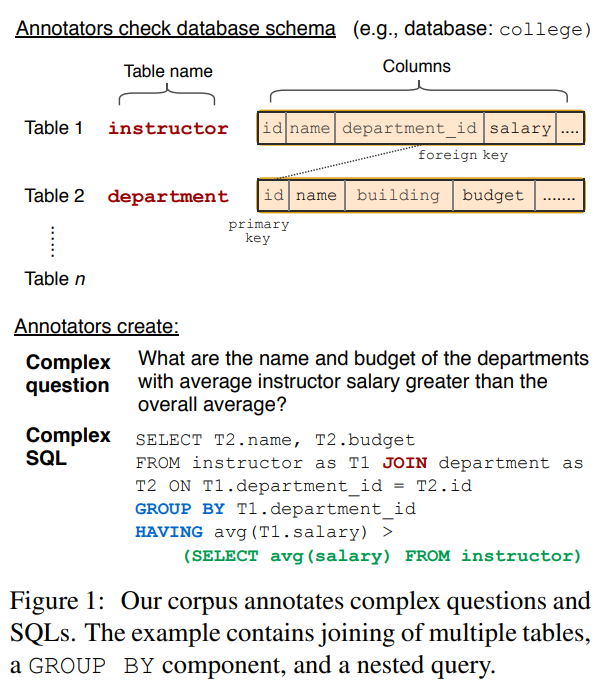


Spider: A Large-Scale Human-Labeled Dataset for Complex and
Cross-Domain Semantic Parsing and Text-to-SQL Task (https://arxiv.org/pdf/1809.08887.pdf)

Github Repo: https://github.com/taoyds/spider

# Configurações básicas do ambiente

In [ ]:
! pip install transformers==4.31.0

# trl: facilitar o fine-tuning
# accelerate: treino distribuído, mixed precision, consumer hardware
# peft: métodos para treino eficiente (sem necessidade de tunar todos os parâmetros do modelo)
! pip install -q -U trl accelerate git+https://github.com/huggingface/peft.git

# bitandbytes: quantização, otimizadores mix precision, multiplicação de matrizes etc
! pip install -q datasets bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Carregando Bibliotecas

In [ ]:
project_path = "/content/drive/MyDrive/Tutorial SBBD/Colab/"
dados_dir = project_path + "Dados/"

In [ ]:
import sys
sys.path.append(project_path)

In [ ]:
from SpiderSchema import *

import pandas as pd
from datasets import load_dataset

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer
from transformers import TrainingArguments
from trl import SFTTrainer
from peft import LoraConfig, get_peft_model

# Funções de pré-processamento

In [ ]:
def generate_prompt(examples, spider_schemas, use_fields=False):
    """
    Generates the prompt for the given example as follows:
    ### SCHEMA:\n<DATABASE STRUCTURE>\n\n### QUESTION:\n<NATURAL LANGUAGE QUESTION>\n\n### SQL QUERY:\n<query>; [end-gen]

    examples: The example to generate the prompt for.
    spider_schemas: The spider schemas object.
    use_fields: Whether to use the database fields in the prompt.
    """
    prompt = ''

    if use_fields:
      fields = "### SCHEMA:\n" + spider_schemas.get_db_schema(examples['db_id'])
      fields.strip()
      prompt += fields

    question = "\n\n### QUESTION:\n" + examples['question']
    question.strip()
    prompt += question

    query = "\n\n### SQL QUERY:\n" + examples['query']
    query.strip()

    if not query.endswith(';'):
        query = query + ' ; [END-GEN]'
    #query = query + SQL_SPECIAL_TOKENS['endoftext'] + '</s>'

    prompt += query

    return prompt.lower()

def preprocess_function(examples, spider_schema, use_fields=False):
    prompts = generate_prompt(examples, spider_schema, use_fields)
    return {'input_text': prompts}

In [ ]:
def get_dataset(table_json: str, dataset_name: str='spider', use_fields: bool = False):

    dataset = load_dataset(dataset_name)
    spider_schema = SpiderSchema(table_json)
    dataset = dataset.map(
        lambda examples: preprocess_function(examples, spider_schema, use_fields),
        remove_columns=dataset["train"].column_names,
    )
    return dataset

# Carregando o Dataset

In [ ]:
dataset_id = 'spider'
spider_schema = dados_dir + 'tables.json'

In [ ]:
dataset = load_dataset(dataset_id)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['db_id', 'query', 'question', 'query_toks', 'query_toks_no_value', 'question_toks'],
        num_rows: 7000
    })
    validation: Dataset({
        features: ['db_id', 'query', 'question', 'query_toks', 'query_toks_no_value', 'question_toks'],
        num_rows: 1034
    })
})

In [ ]:
dataset['train'].select([0])['db_id']

['department_management']

In [ ]:
sschema = SpiderSchema(spider_schema)

In [ ]:
print(sschema.get_db_schema(dataset['train'].select([0])['db_id'][0]))

Table department, columns = [*,Department_ID,Name,Creation,Ranking,Budget_in_Billions,Num_Employees]
Table head, columns = [*,head_ID,name,born_state,age]
Table management, columns = [*,department_ID,head_ID,temporary_acting]
Foreign_keys = [department.Department_ID,head.head_ID,management.department_ID]
Primary_keys = [management.head_ID = head.head_ID,management.department_ID = department.Department_ID]


In [ ]:
print(dataset['train'].select([0])['query'])

['SELECT count(*) FROM head WHERE age  >  56']


In [ ]:
dataset = get_dataset(spider_schema, dataset_id, use_fields=True)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_text'],
        num_rows: 7000
    })
    validation: Dataset({
        features: ['input_text'],
        num_rows: 1034
    })
})

# Formato de Entrada para Fine-Tuning do modelo

In [ ]:
print(dataset['train'][0]['input_text'])

### schema:
table department, columns = [*,department_id,name,creation,ranking,budget_in_billions,num_employees]
table head, columns = [*,head_id,name,born_state,age]
table management, columns = [*,department_id,head_id,temporary_acting]
foreign_keys = [department.department_id,head.head_id,management.department_id]
primary_keys = [management.head_id = head.head_id,management.department_id = department.department_id]

### question:
how many heads of the departments are older than 56 ?

### sql query:
select count(*) from head where age  >  56 ; [end-gen]


# Load the Model

In [ ]:
model_name = "TinyPixel/Llama-2-7B-bf16-sharded"   #"meta-llama/Llama-2-7b-hf"

In [ ]:
# BitsAndBytes é um framework com funções customizadas para
# otimização com precisão 8-bit, multiplicações de matrizes e
# funções de quantização
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,   # Utiliza precisão de 4 bits para comprimir o modelo
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,   # os gradientes dos pesos são computados em 16-bit
)

model = AutoModelForCausalLM.from_pretrained(
    "TinyPixel/Llama-2-7B-bf16-sharded",
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


# Load the Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({"additional_special_tokens" : ['[end-gen]']})

# resize model embedding
model.resize_token_embeddings(len(tokenizer))

Embedding(32001, 4096)

In [ ]:
tokenizer.get_vocab()['[end-gen]']

32000

# PEFT Configuration

In [ ]:
lora_alpha = 8
lora_dropout = 0.1
lora_r = 8   # lora rank default

peft_config = LoraConfig(
    lora_alpha = lora_alpha,
    lora_dropout = lora_dropout,
    r = lora_r,
    bias = "none",
    task_type = "CAUSAL_LM"     # possíveis task types: CAUSAL_LM, FEATURE_EXTRACTION, QUESTION_ANS, SEQ_2_SEQ_LM, SEQ_CLS and TOKEN_CLS.
)

# Load Trainer

In [ ]:
output_dir = project_path + "models/results2"
per_device_train_batch_size = 8
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 100
logging_steps = 25
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 200    # ((7000 / batch_size=8) / grad_accu_step=4) = 218
#max_steps = 430    # ((7000 / batch_size=4) / grad_accu_steps=4) = 437
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir = output_dir,
    per_device_train_batch_size = per_device_train_batch_size,
    gradient_accumulation_steps = gradient_accumulation_steps,
    optim = optim,
    save_steps = save_steps,
    logging_steps = logging_steps,
    learning_rate = learning_rate,
    fp16 = True,
    max_grad_norm = max_grad_norm,
    max_steps = max_steps,
    warmup_ratio = warmup_ratio,
    group_by_length = True,
    lr_scheduler_type = lr_scheduler_type
)

In [ ]:
max_seq_length = 512

trainer = SFTTrainer(
    model = model,
    train_dataset = dataset['train'],
    peft_config = peft_config,
    dataset_text_field = "input_text",
    max_seq_length = max_seq_length,
    tokenizer = tokenizer,
    args = training_arguments
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:133: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:207: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [ ]:
# Para deixar o treino mais estável iremos fazer um casting nas camadas de normalização do modelo.
for name, module in trainer.model.named_modules():
  if "norm" in name:
    module = module.to(torch.float32)

In [ ]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,1.649900
50,1.862600
75,0.659800
100,0.689300
125,0.581100
150,0.567800
175,0.533800
200,0.477600


TrainOutput(global_step=200, training_loss=0.8777500295639038, metrics={'train_runtime': 6995.771, 'train_samples_per_second': 0.915, 'train_steps_per_second': 0.029, 'total_flos': 4.341566992259482e+16, 'train_loss': 0.8777500295639038, 'epoch': 0.91})

In [ ]:
trainer.model.save_pretrained(project_path + "models/outputs2")

# Carregando Modelo Tunado com QLoRA

In [ ]:
model_name = "TinyPixel/Llama-2-7B-bf16-sharded"

In [ ]:
# BitsAndBytes é um framework com funções customizadas para
# otimização com precisão 8-bit, multiplicações de matrizes e
# funções de quantização
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,   # Utiliza precisão de 4 bits para comprimir o modelo
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,   # os gradientes dos pesos são computados em 16-bit
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({"additional_special_tokens" : ['[end-gen]']})

# resize model embedding
model.resize_token_embeddings(len(tokenizer))

Embedding(32001, 4096)

In [ ]:
lora_config = LoraConfig.from_pretrained(project_path + "models/outputs2")
model = get_peft_model(model, lora_config)

# Inferência: Exemplo 1

In [ ]:
dataset['validation'][0]

{'input_text': '### schema:\ntable concert, columns = [*,concert_id,concert_name,theme,stadium_id,year]\ntable singer, columns = [*,singer_id,name,country,song_name,song_release_year,age,is_male]\ntable singer_in_concert, columns = [*,concert_id,singer_id]\ntable stadium, columns = [*,stadium_id,location,name,capacity,highest,lowest,average]\nforeign_keys = [stadium.stadium_id,singer.singer_id,concert.concert_id,singer_in_concert.concert_id]\nprimary_keys = [concert.stadium_id = stadium.stadium_id,singer_in_concert.singer_id = singer.singer_id,singer_in_concert.concert_id = concert.concert_id]\n\n### question:\nhow many singers do we have?\n\n### sql query:\nselect count(*) from singer ; [end-gen]'}

In [ ]:
input = "### schema:\ntable concert, columns = [*,concert_id,concert_name,theme,stadium_id,year]" \
"\ntable singer, \columns = [*,singer_id,name,country,song_name,song_release_year,age,is_male]"\
"\ntable singer_in_concert, columns = [*,concert_id,singer_id]"\
"\ntable stadium, columns = [*,stadium_id,location,name,capacity,highest,lowest,average]"\
"\nforeign_keys = [stadium.stadium_id,singer.singer_id,concert.concert_id,singer_in_concert.concert_id]"\
"\nprimary_keys = [concert.stadium_id = stadium.stadium_id,singer_in_concert.singer_id = singer.singer_id,singer_in_concert.concert_id = concert.concert_id]\n\n"\
"### question:\nhow many singers do we have?\n\n### sql query:\n"
device = "cuda:0"

inputs = tokenizer(input, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=50, eos_token_id=[tokenizer.get_vocab()["#"], tokenizer.get_vocab()[";"], tokenizer.get_vocab()["[end-gen]"]])
print(tokenizer.decode(outputs[0], skip_special_tokens=False))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


<s> ### schema:
table concert, columns = [*,concert_id,concert_name,theme,stadium_id,year]
table singer, \columns = [*,singer_id,name,country,song_name,song_release_year,age,is_male]
table singer_in_concert, columns = [*,concert_id,singer_id]
table stadium, columns = [*,stadium_id,location,name,capacity,highest,lowest,average]
foreign_keys = [stadium.stadium_id,singer.singer_id,concert.concert_id,singer_in_concert.concert_id]
primary_keys = [concert.stadium_id = stadium.stadium_id,singer_in_concert.singer_id = singer.singer_id,singer_in_concert.concert_id = concert.concert_id]

### question:
how many singers do we have?

### sql query:
select count(*) from singer

###


# Inferência: Exemplo 2

In [ ]:
dataset['validation'][4]

{'input_text': "### schema:\ntable concert, columns = [*,concert_id,concert_name,theme,stadium_id,year]\ntable singer, columns = [*,singer_id,name,country,song_name,song_release_year,age,is_male]\ntable singer_in_concert, columns = [*,concert_id,singer_id]\ntable stadium, columns = [*,stadium_id,location,name,capacity,highest,lowest,average]\nforeign_keys = [stadium.stadium_id,singer.singer_id,concert.concert_id,singer_in_concert.concert_id]\nprimary_keys = [concert.stadium_id = stadium.stadium_id,singer_in_concert.singer_id = singer.singer_id,singer_in_concert.concert_id = concert.concert_id]\n\n### question:\nwhat is the average, minimum, and maximum age of all singers from france?\n\n### sql query:\nselect avg(age) ,  min(age) ,  max(age) from singer where country  =  'france' ; [end-gen]"}

In [ ]:
input = dataset['validation'][4]['input_text'].split("### sql query:")[0] + "### sql query:\n"
device = "cuda:0"

inputs = tokenizer(input, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=50, eos_token_id=[tokenizer.get_vocab()["#"], tokenizer.get_vocab()[";"], tokenizer.get_vocab()["[end-gen]"]])
print(tokenizer.decode(outputs[0], skip_special_tokens=False))

<s> ### schema:
table concert, columns = [*,concert_id,concert_name,theme,stadium_id,year]
table singer, columns = [*,singer_id,name,country,song_name,song_release_year,age,is_male]
table singer_in_concert, columns = [*,concert_id,singer_id]
table stadium, columns = [*,stadium_id,location,name,capacity,highest,lowest,average]
foreign_keys = [stadium.stadium_id,singer.singer_id,concert.concert_id,singer_in_concert.concert_id]
primary_keys = [concert.stadium_id = stadium.stadium_id,singer_in_concert.singer_id = singer.singer_id,singer_in_concert.concert_id = concert.concert_id]

### question:
what is the average, minimum, and maximum age of all singers from france?

### sql query:
select avg(age), min(age), max(age) from singer where country = 'France'

###


# Inferência: Exemplo 3

In [ ]:
dataset['validation'][150]

{'input_text': '### schema:\ntable car_makers, columns = [*,id,maker,fullname,country]\ntable car_names, columns = [*,makeid,model,make]\ntable cars_data, columns = [*,id,mpg,cylinders,edispl,horsepower,weight,accelerate,year]\ntable continents, columns = [*,contid,continent]\ntable countries, columns = [*,countryid,countryname,continent]\ntable model_list, columns = [*,modelid,maker,model]\nforeign_keys = [continents.contid,countries.countryid,car_makers.id,model_list.modelid,car_names.makeid,cars_data.id]\nprimary_keys = [countries.continent = continents.contid,car_makers.country = countries.countryid,model_list.maker = car_makers.id,car_names.model = model_list.model,cars_data.id = car_names.makeid]\n\n### question:\nwhat are the names and ids of all makers with more than 3 models?\n\n### sql query:\nselect t1.fullname ,  t1.id from car_makers as t1 join model_list as t2 on t1.id  =  t2.maker group by t1.id having count(*)  >  3;'}

In [ ]:
input = dataset['validation'][150]['input_text'].split("### sql query:")[0] + "### sql query:\n"
device = "cuda:0"

inputs = tokenizer(input, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=50, eos_token_id=[tokenizer.get_vocab()["#"], tokenizer.get_vocab()[";"], tokenizer.get_vocab()["[end-gen]"]])
print(tokenizer.decode(outputs[0], skip_special_tokens=False))

<s> ### schema:
table car_makers, columns = [*,id,maker,fullname,country]
table car_names, columns = [*,makeid,model,make]
table cars_data, columns = [*,id,mpg,cylinders,edispl,horsepower,weight,accelerate,year]
table continents, columns = [*,contid,continent]
table countries, columns = [*,countryid,countryname,continent]
table model_list, columns = [*,modelid,maker,model]
foreign_keys = [continents.contid,countries.countryid,car_makers.id,model_list.modelid,car_names.makeid,cars_data.id]
primary_keys = [countries.continent = continents.contid,car_makers.country = countries.countryid,model_list.maker = car_makers.id,car_names.model = model_list.model,cars_data.id = car_names.makeid]

### question:
what are the names and ids of all makers with more than 3 models?

### sql query:
select maker,count(*) as num_models from car_makers group by maker having count(*) > 3

###
